# Translate French -- English
## *Only Questions as of now
### Purpose: Learning Text processing + RNN (Attention + LSTM + Bi-Directional RNNs)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
from fastai.text import *

In [44]:
PATH = Path('/home/devendra/projects/fastai/data/translate/fr-en')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='europarl-v7.fr-en'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [19]:
en_fname

PosixPath('/home/devendra/projects/fastai/data/translate/fr-en/europarl-v7.fr-en.en')

### We only want to deal with questions as of now. Therefore applying the regex on english sentences starting with What, When etc. type questions

In [20]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [21]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [22]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [23]:
qs[:5], len(qs)

([('Why has no air quality test been done on this particular building since we were elected?',
   "Comment se fait-il qu'aucun test de qualité de l'air n'ait été réalisé dans ce bâtiment depuis notre élection ?"),
  ('Why has there been no Health and Safety Committee meeting since 1998?',
   "Comment se fait-il que le comité de santé et d'hygiène ne se soit plus réuni depuis 1998 ?"),
  ('Why has there been no fire drill, either in the Brussels Parliament buildings or the Strasbourg Parliament buildings?',
   "Comment se fait-il que nous n'ayons jamais fait d'exercice d'évacuation dans les bâtiments du Parlement de Bruxelles et de Strasbourg ?"),
  ('Why are there no fire instructions?',
   "Comment se fait-il qu'il n'y ait pas de consignes en cas d'incendie ?"),
  ('Why have the staircases not been improved since my accident?',
   "Comment se fait-il que les escaliers n'aient pas été améliorés depuis mon accident ?")],
 14803)

In [24]:
en_qs,fr_qs = zip(*qs)

In [31]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

### No Argument 'en' as the default tokenizer is English

In [32]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

### Successfully Tokenized out French and English Parallel sentence-sets

In [34]:
en_tok[0], fr_tok[0]

(['why',
  'has',
  'no',
  'air',
  'quality',
  'test',
  'been',
  'done',
  'on',
  'this',
  'particular',
  'building',
  'since',
  'we',
  'were',
  'elected',
  '?'],
 ['comment',
  'se',
  'fait',
  '-',
  'il',
  "qu'",
  'aucun',
  'test',
  'de',
  'qualité',
  'de',
  "l'",
  'air',
  "n'",
  'ait',
  'été',
  'réalisé',
  'dans',
  'ce',
  'bâtiment',
  'depuis',
  'notre',
  'élection',
  '?'])

In [35]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(31.0, 35.0)

In [36]:
keep = np.array([len(o)<30 for o in en_tok])

In [37]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [40]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [41]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [45]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [46]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [47]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [48]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [49]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['comment',
  'se',
  'fait',
  '-',
  'il',
  "qu'",
  'aucun',
  'test',
  'de',
  'qualité',
  'de',
  "l'",
  'air',
  "n'",
  'ait',
  'été',
  'réalisé',
  'dans',
  'ce',
  'bâtiment',
  'depuis',
  'notre',
  'élection',
  '?',
  '_eos_'],
 8556,
 11222)

### So far, So Good...Managed to save the tokenized clean data and avoided future redundant pre-processing of data

## Word Vectors 

### Using the fastText library from facebook research
### Can be installed from -> https://github.com/facebookresearch/fastText.git
### Neat Trick : Instead of downloading/cloning then running the script, this can be used:


### ! pip install git+https://github.com/facebookresearch/fastText.git



In [51]:
import fastText as ft

### To use the fastText library, you'll need to download fasttext word vectors for your language (download the 'bin plus text' ones).
### Link For all languages : [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md]
### English : bin+text[https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip]
### French: bin+text[https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip]

In [54]:
en_vecs = ft.load_model(str((PATH/'wiki.en/wiki.en.bin')))
fr_vecs = ft.load_model(str((PATH/'wiki.fr/wiki.fr.bin')))

In [55]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [56]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [57]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [59]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [60]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

## Model Data

In [61]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(30, 33)

In [62]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [63]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [64]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(11713, 1325)

In [65]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [66]:
bs=125

In [67]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [68]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [69]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(25, 6), (21, 13), (25, 14), (10, 4), (19, 11)]

## Initial Model

In [70]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [71]:
nh,nl = 256,2

In [72]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [73]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [74]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [75]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

531 ["qu'", "d'", 'l’', '-ce', "n'"]
251 ['t_up', '’s', ':', '000', '1']


 65%|██████▍   | 61/94 [00:13<00:07,  4.62it/s, loss=37]  

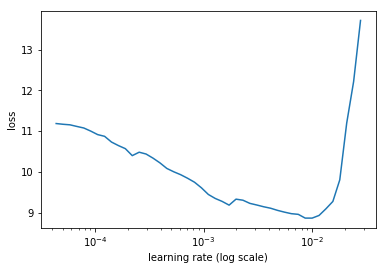

In [76]:
learn.lr_find()
learn.sched.plot()

In [77]:
lr=3e-3

In [78]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      6.43034    5.86213   
    1      5.793968   5.0093                              
    2      5.055109   4.788122                            
    3      4.870533   4.686172                            
    4      4.262737   4.31536                             
    5      4.073639   4.111049                            
    6      3.8919     4.066538                            
    7      3.645197   3.936129                            
    8      3.571479   3.877398                            
    9      3.409587   3.752161                            
    10     3.430935   3.701442                            
    11     3.143175   3.685953                            


[array([3.68595])]

In [79]:
learn.save('initial')

In [80]:
learn.load('initial')

## Test

In [81]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelle est la situation concernant la réforme judiciaire et les mesures anticorruption qui sont encore nécessaires ? _eos_
what is the situation when it comes to the judicial reform and anti - corruption measures that are still needed ? _eos_
what is the situation the the the the the the the the the the ? ? ? _eos_ _eos_

quelle aurait été l' alternative si l' on n' avait pas entériné , pour l' essentiel , le pacte de confiance sur l' emploi ? _eos_
what might the alternative have been if the confidence pact for employment had not , in essence , been ratified ? _eos_
what would would the the the the the the the the the the the the the the the the the ? ? ? _eos_ _eos_ _eos_

quelle politique l' union , et non pas les états membres , doit - elle poursuivre à moyen et à long terme ? _eos_
what policy should the union - and not the member states - pursue in the medium and long - term ? _eos_
what policy the the , , , , , , , , the the the the the the ? ? ? _eos_ _eos_

quel était le pourc

# Next Target:
## Bidirectional LSTM
## Teacher Forcing
## Attention Model
